# Data Cleaning

In [174]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.utils.data import get_outliers_inliers
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

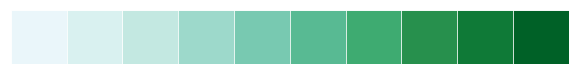

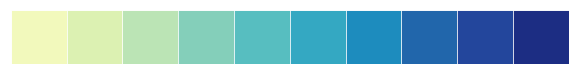

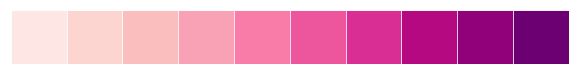

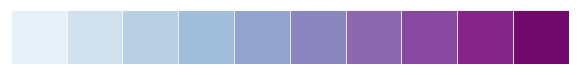

In [80]:
# Create color palettes for seaborn
sns.palplot(sns.color_palette("BuGn", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
RdPu = ['#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
sns.palplot(sns.color_palette("RdPu", 10))
BuPu = ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']
sns.palplot(sns.color_palette("BuPu", 10))

In [81]:
# Read Excel file into dataframe
df = pd.read_excel('credit_card_default.xls')

In [82]:
# Rename columns
df.columns = df.iloc[0]

In [83]:
# Sanity check
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [84]:
# Reset index, eliminate redundant row
df = df.drop(["ID"]).reset_index(drop = True)

In [85]:
# Check progress
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [86]:
# Check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null object
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null object
PAY_0                         30000 non-null object
PAY_2                         30000 non-null object
PAY_3                         30000 non-null object
PAY_4                         30000 non-null object
PAY_5                         30000 non-null object
PAY_6                         30000 non-null object
BILL_AMT1                     30000 non-null object
BILL_AMT2                     30000 non-null object
BILL_AMT3                     30000 non-null object
BILL_AMT4                     30000 non-null object
BILL_AMT5                     30000 non-null object
BILL_AMT6                     30000 non-null object
PAY_AMT

In [87]:
# Change column types to integers
df = df.astype("int64")

In [88]:
# Change SEX column to Male/Female
df["SEX"] = np.where(df.SEX == 1, "Male", "Female")
df.SEX.value_counts()

Female    18112
Male      11888
Name: SEX, dtype: int64

In [90]:
# Check data for outliers and other irregularities
df.describe()

ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [91]:
# Drop rows with non-sensical values from EDUCATION column
ed_todrop = df[(df.EDUCATION>4) | (df.EDUCATION==0)].index
df.drop(ed_todrop, inplace=True)
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      123
Name: EDUCATION, dtype: int64

In [92]:
# Drop rows with non-sensical values from MARRIAGE column
mar_todrop = df[(df.MARRIAGE>4) | (df.MARRIAGE==0)].index
df.drop(mar_todrop, inplace=True)
df.MARRIAGE.value_counts()

2    15806
1    13477
3      318
Name: MARRIAGE, dtype: int64

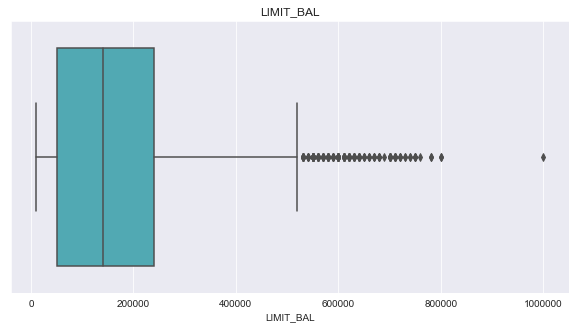

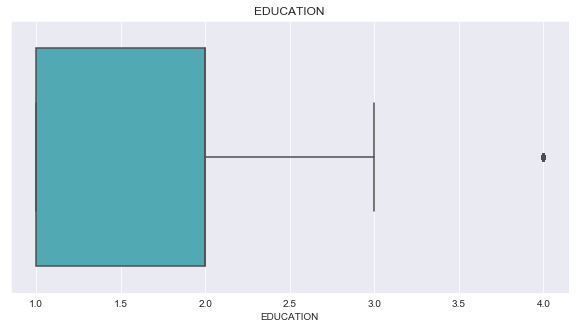

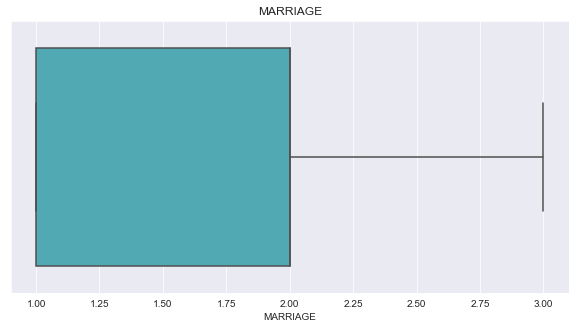

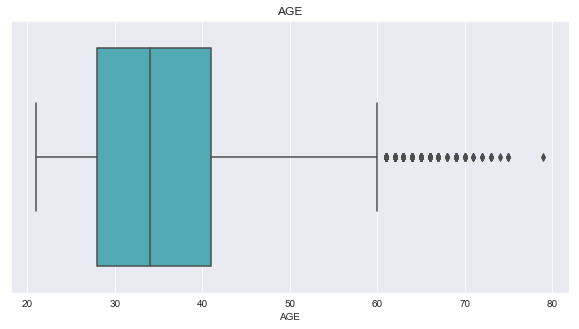

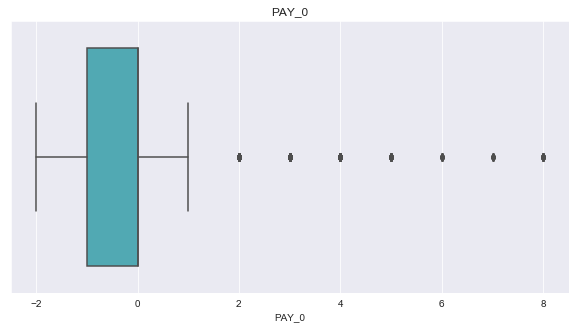

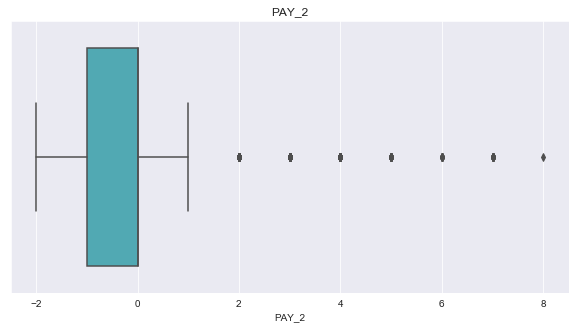

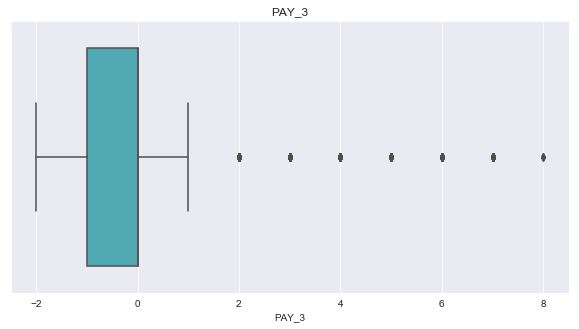

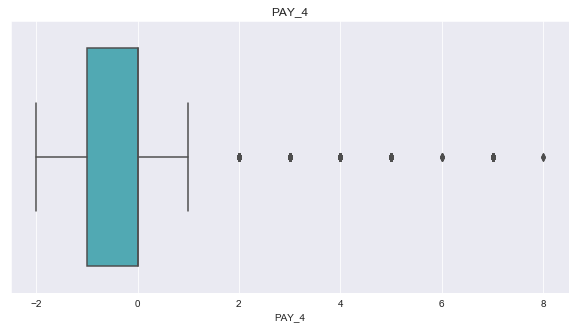

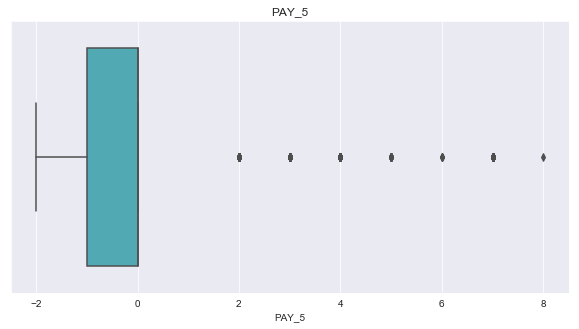

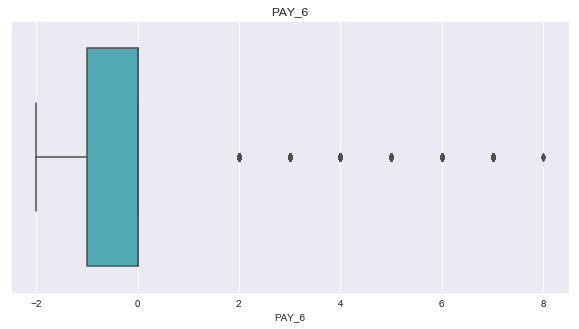

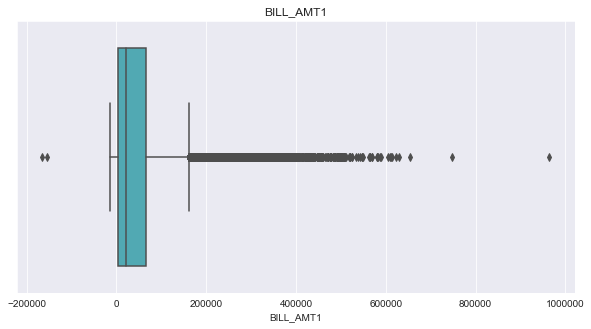

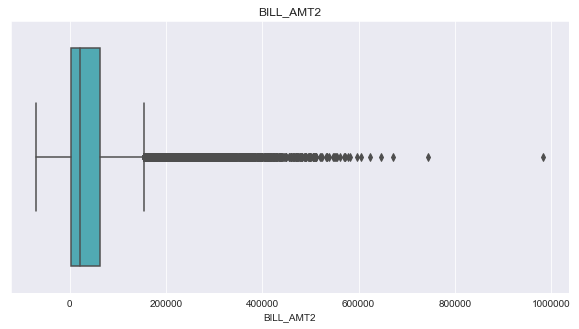

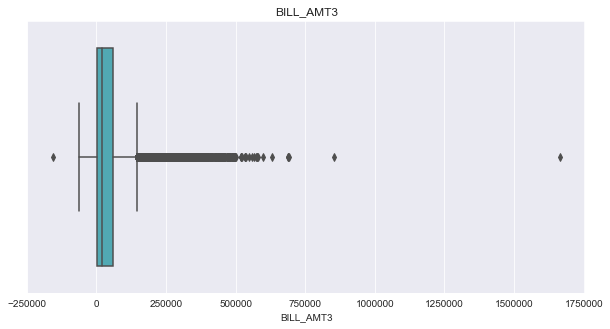

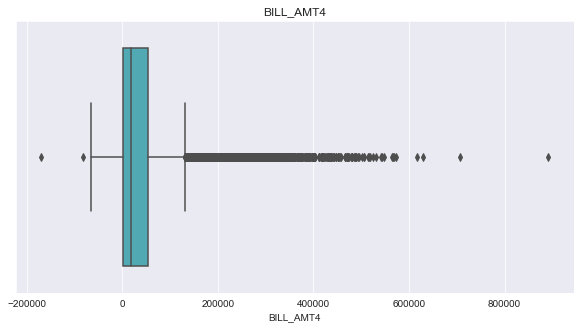

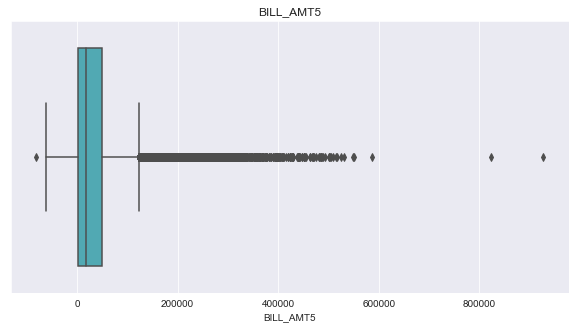

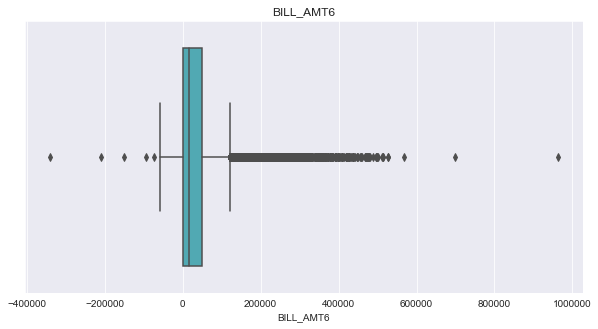

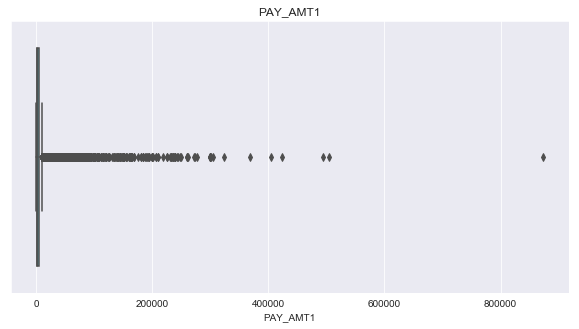

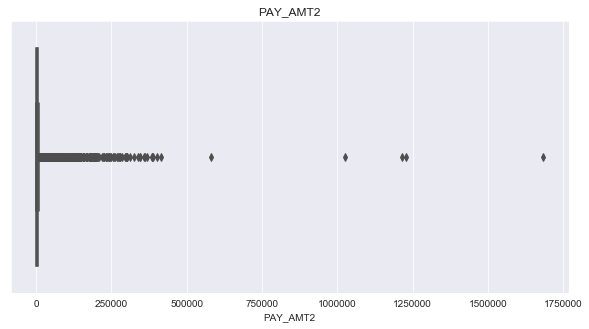

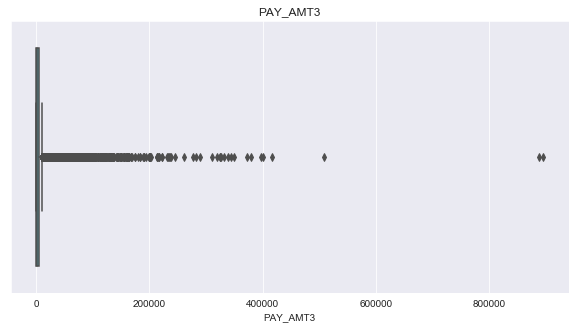

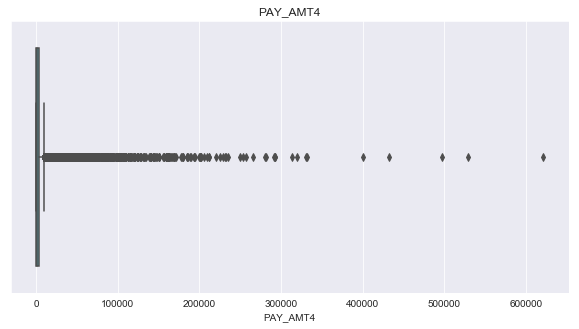

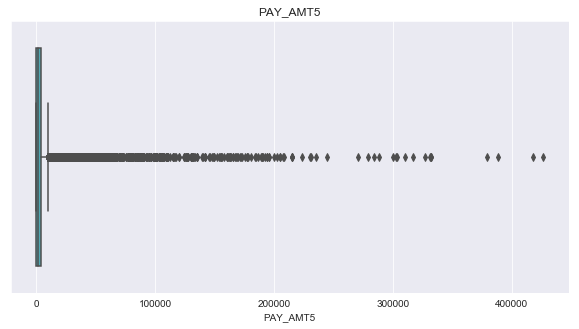

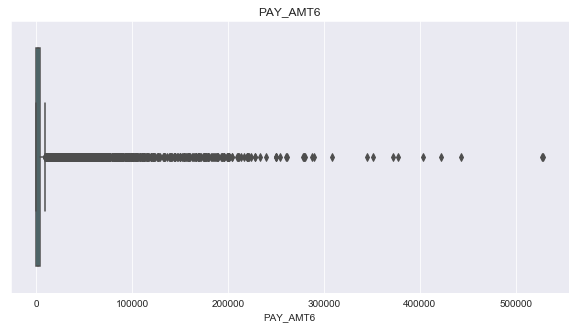

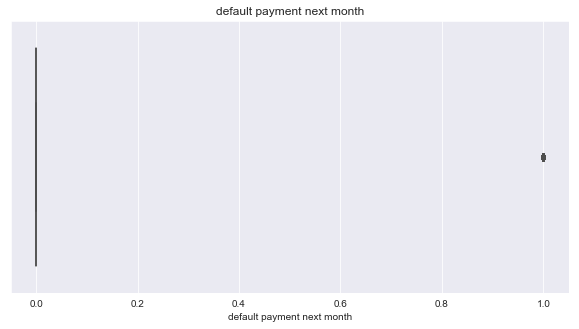

In [93]:
# Create boxplot for all numerical values to check distributions
for column in df.columns:
    if column != "SEX":
        sns.boxplot(x = column, palette = "YlGnBu", data = df).set_title(column)
        plt.show()

In [94]:
df.drop(["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis = 1, inplace = True)

In [95]:
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,Female,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [96]:
# Replace spaces with undersocre in column names
df.columns = df.columns.str.replace(' ', '_')

In [97]:
# Sanity Check
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,Female,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory Data Analysis

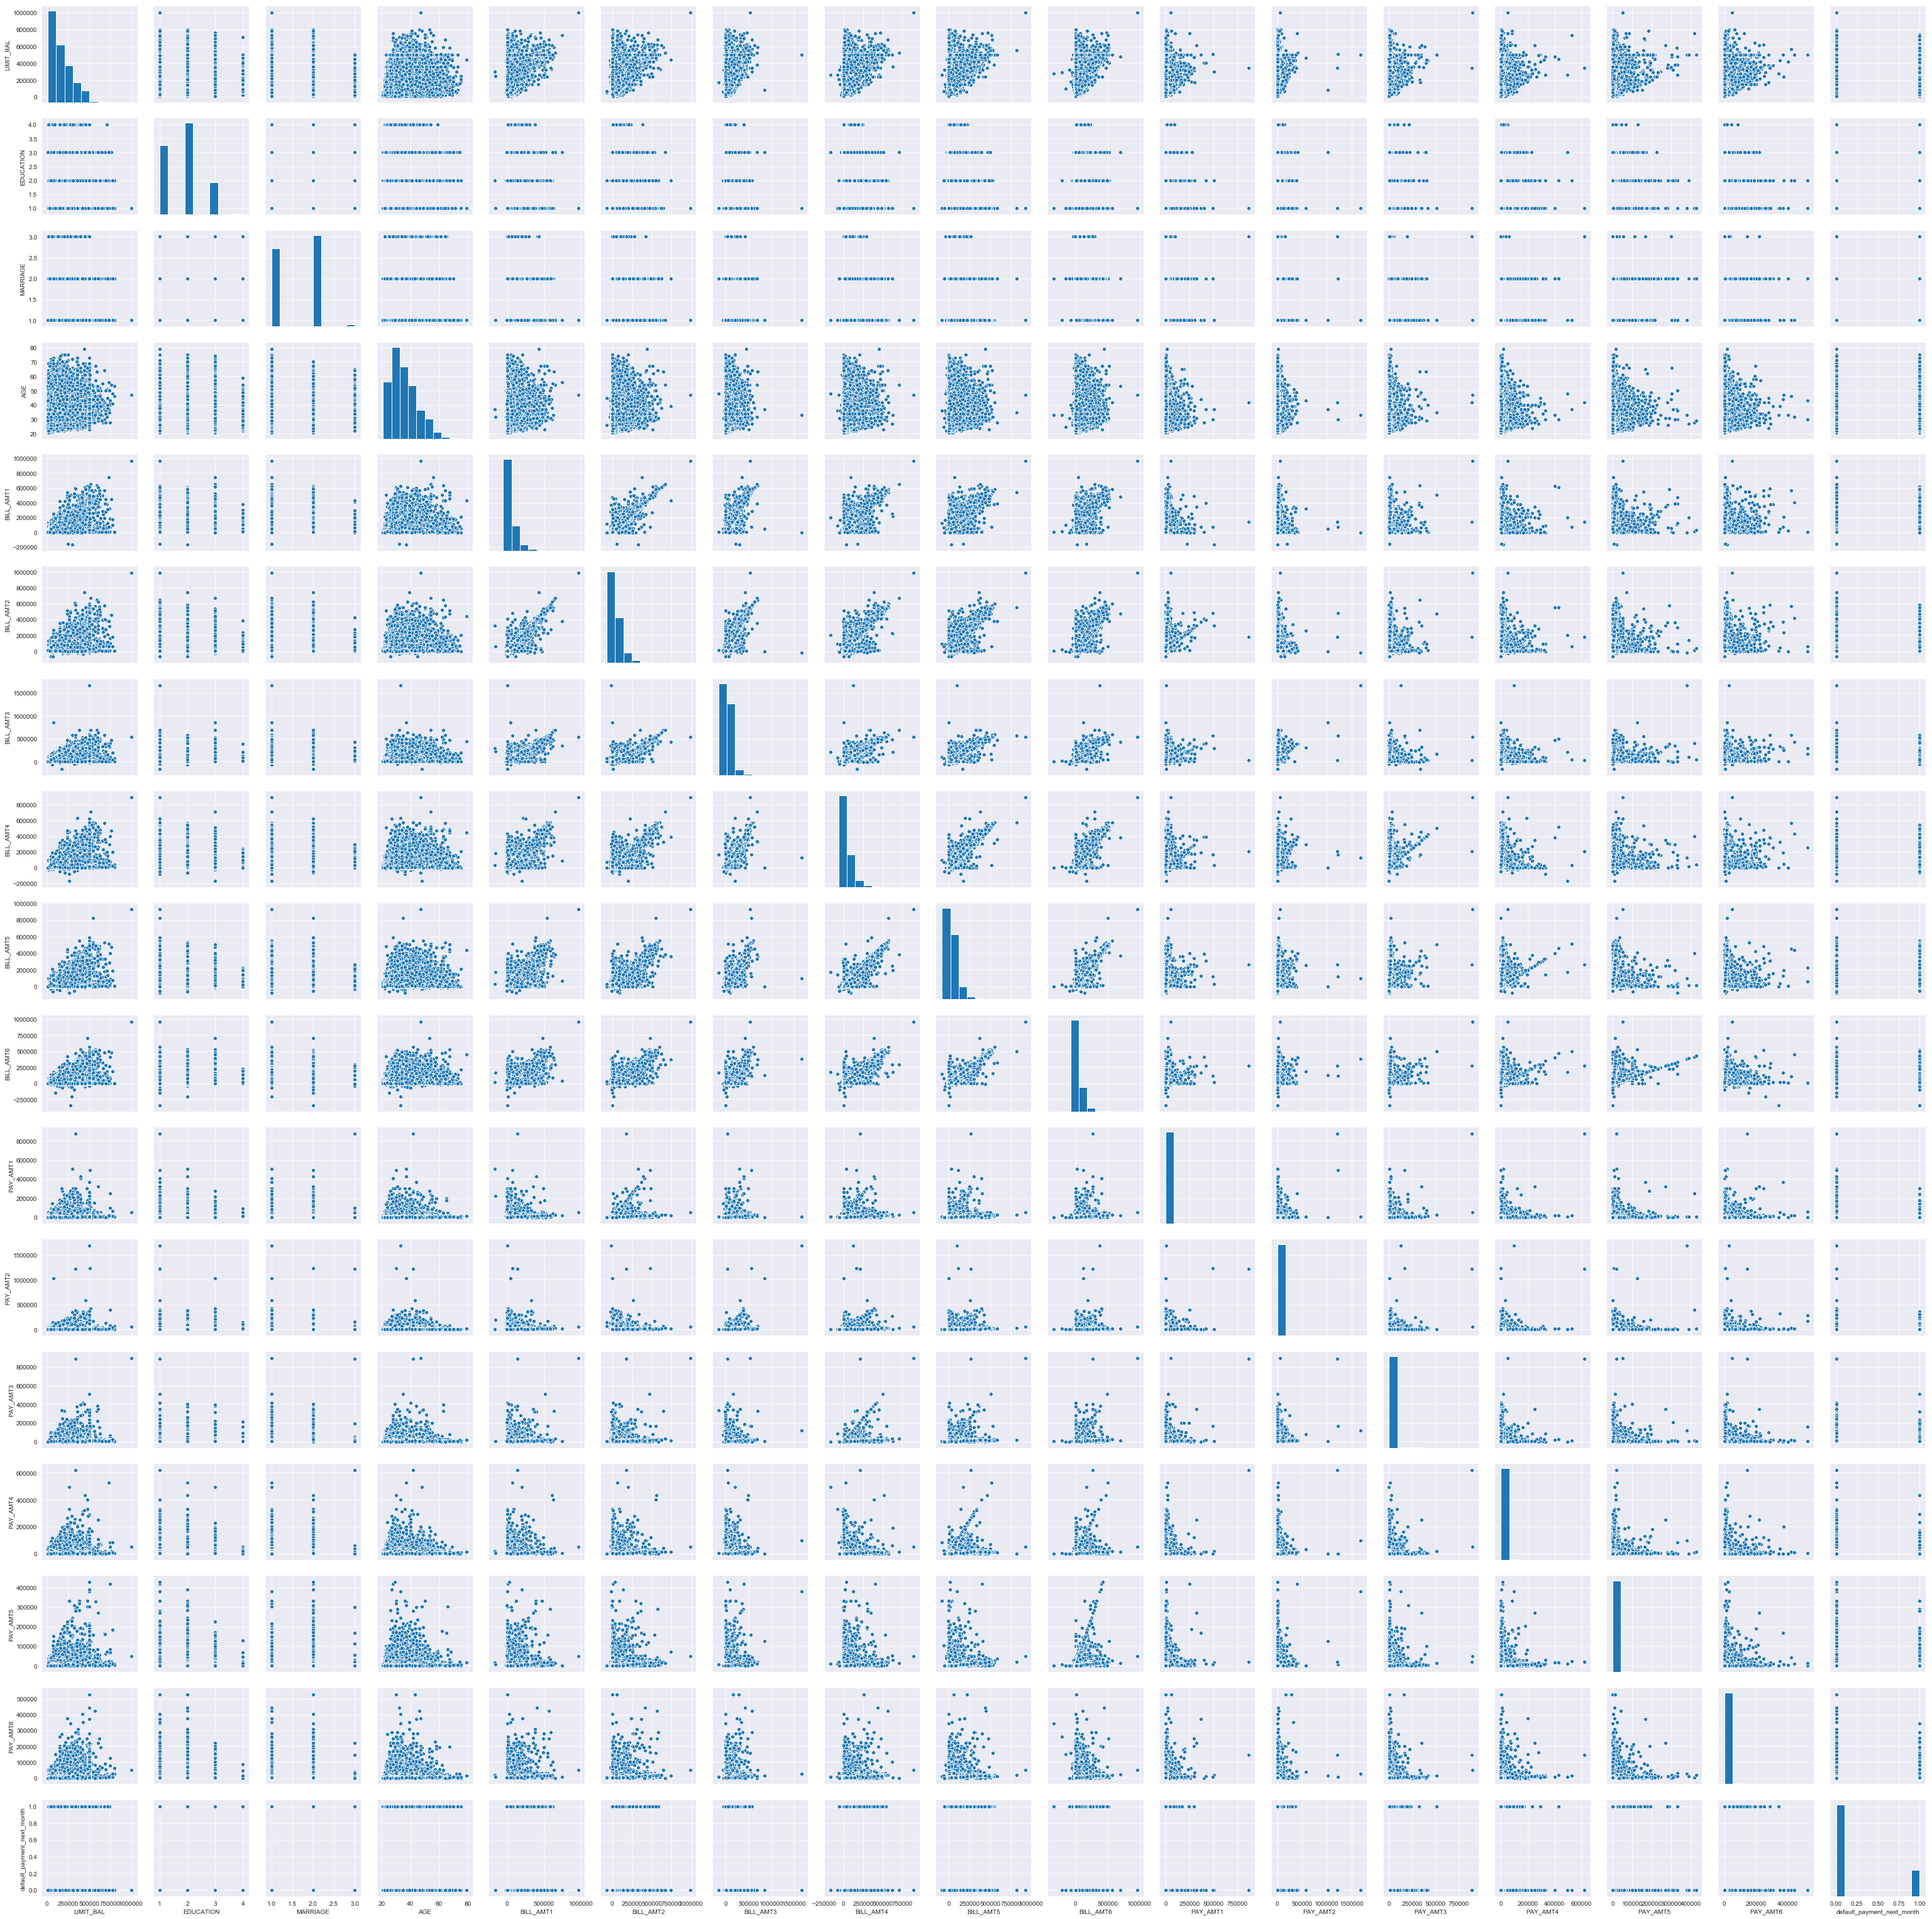

In [67]:
# Explore relationships between variables using a pairplot
sns.pairplot(df, palette = "RdPU")
plt.show()

In [68]:
# Correlation Matrix
df.corr()

ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,
LIMIT_BAL,1.000000,-0.244039,-0.109756,0.144214,0.283695,0.276673,0.281738,0.293442,0.295316,0.289701,0.195666,0.177669,0.210523,0.203263,0.217251,0.219676,-0.154357
EDUCATION,-0.244039,1.000000,-0.147977,0.187425,0.005120,0.001250,-0.003499,-0.014428,-0.018165,-0.015190,-0.045972,-0.038628,-0.051966,-0.043094,-0.049469,-0.053670,0.049087
MARRIAGE,-0.109756,-0.147977,1.000000,-0.418284,-0.024971,-0.022505,-0.026171,-0.023902,-0.026148,-0.022198,-0.005120,-0.008058,-0.002921,-0.013957,-0.002882,-0.006024,-0.026903
AGE,0.144214,0.187425,-0.418284,1.000000,0.054704,0.052385,0.051839,0.049839,0.048323,0.046712,0.025440,0.022402,0.029478,0.021567,0.021511,0.019139,0.014424
BILL_AMT1,0.283695,0.005120,-0.024971,0.054704,1.000000,0.951255,0.891886,0.861238,0.831406,0.804834,0.140489,0.098947,0.156813,0.157643,0.165041,0.175798,-0.019303
BILL_AMT2,0.276673,0.001250,-0.022505,0.052385,0.951255,1.000000,0.927801,0.893418,0.861465,0.833846,0.280903,0.100613,0.151052,0.146479,0.155457,0.170718,-0.013710
BILL_AMT3,0.281738,-0.003499,-0.026171,0.051839,0.891886,0.927801,1.000000,0.925094,0.885669,0.855571,0.244564,0.318039,0.131112,0.142468,0.177549,0.179539,-0.013494
BILL_AMT4,0.293442,-0.014428,-0.023902,0.049839,0.861238,0.893418,0.925094,1.000000,0.940458,0.902348,0.233241,0.208175,0.300270,0.129010,0.160036,0.175067,-0.009474
BILL_AMT5,0.295316,-0.018165,-0.026148,0.048323,0.831406,0.861465,0.885669,0.940458,1.000000,0.947211,0.218717,0.181988,0.252535,0.293204,0.140896,0.162081,-0.006226


In [69]:
# Meaningful correlations, exploring collinearity
abs(df.corr()) > 0.60

ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,
LIMIT_BAL,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
EDUCATION,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MARRIAGE,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AGE,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
BILL_AMT1,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT2,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT3,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT4,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT5,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False


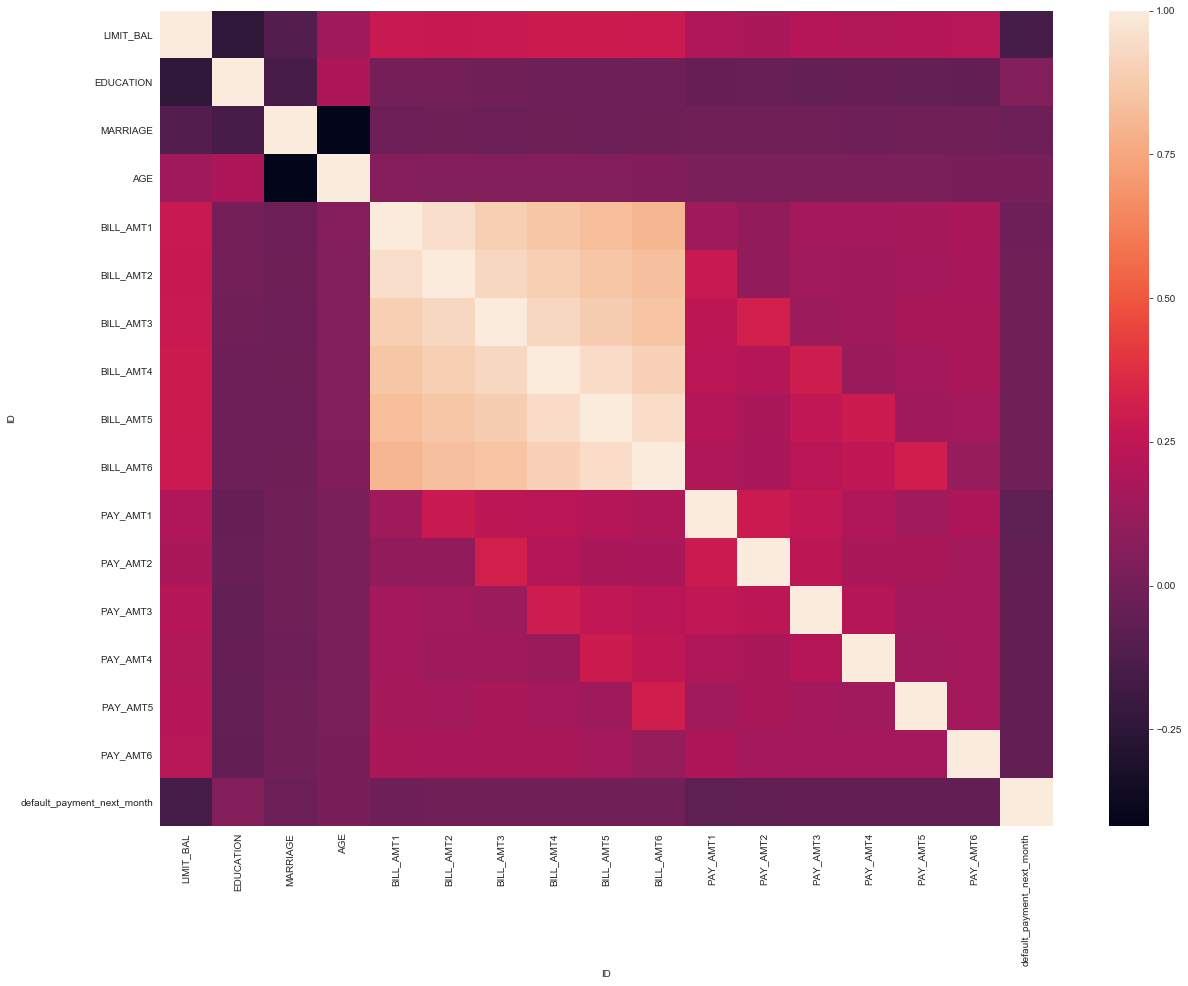

In [70]:
# Heatmap
plt.figure(figsize = (20, 15))
sns.heatmap(df.corr())
plt.show()

Target Variable
default_payment_next_month
0    22996
1     6605
Name: default_payment_next_month, dtype: int64


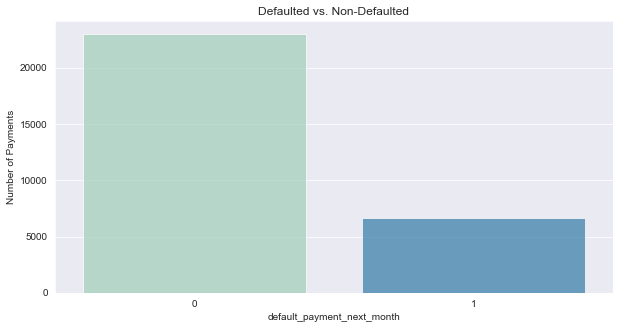

In [71]:
# Default Count. Where 0 = No and 1 = Yes
print('Target Variable')
print(df.groupby(["default_payment_next_month"]).default_payment_next_month.count())

# Target Variable Countplot
sns.set_style("darkgrid")
plt.figure(figsize = (10, 5))
sns.countplot(df["default_payment_next_month"], alpha = .70, palette = "YlGnBu")
plt.title("Defaulted vs. Non-Defaulted")
plt.ylabel("Number of Payments")
plt.show()

Defaults by gender


default_payment_next_month      0     1
SEX                                    
Female                      14111  3744
Male                         8885  2861


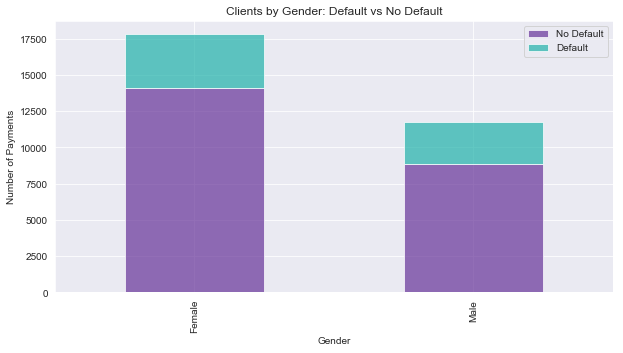

In [77]:
# Defaults by gender
print("Defaults by gender")

print('\n')
print(df.groupby(["SEX","default_payment_next_month"]).SEX.count().unstack())

# Client gender visualization
gender = df.groupby(["SEX","default_payment_next_month"]).SEX.count().unstack()
p1 = gender.plot(kind = "bar", stacked = True, 
                   title = "Clients by Gender: Default vs No Default", 
                   color = ["rebeccapurple", "lightseagreen"], alpha = .70)
p1.set_xlabel("Gender")
p1.set_ylabel("Number of Payments")
p1.legend(["No Default","Default"])
plt.show()

Defaults by education level


default_payment_next_month      0     1
EDUCATION                              
1                            8545  2036
2                           10695  3329
3                            3640  1233
4                             116     7


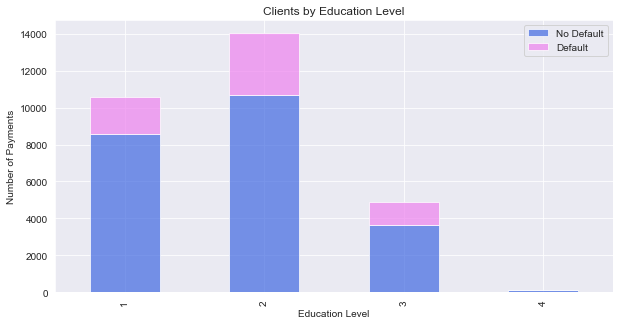

In [98]:
# Defaults by education level
print("Defaults by education level")

print("\n")
print(df.groupby(["EDUCATION", "default_payment_next_month"]).EDUCATION.count().unstack())

#Client education visualization, where 1 = graduate school; 2 = university; 3 = high school; 4 = others.
education = df.groupby(["EDUCATION", "default_payment_next_month"]).EDUCATION.count().unstack()
pl2 = education.plot(kind = "bar", stacked = True,
                    title = "Clients by Education Level", 
                    color = ["royalblue", "violet"], alpha = .70)
pl2.set_xlabel("Education Level")
pl2.set_ylabel("Number of Payments")
pl2.legend(["No Default", "Default"])
plt.show()

Defaults by civil status


default_payment_next_month      0     1
MARRIAGE                               
1                           10285  3192
2                           12477  3329
3                             234    84


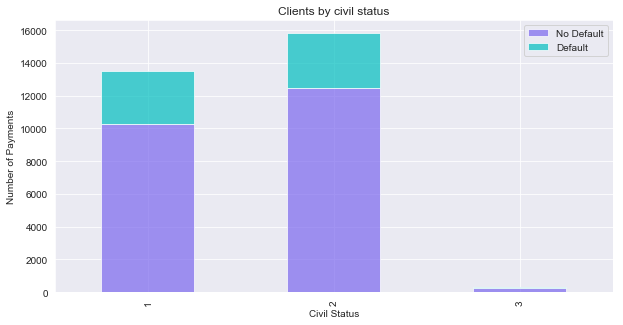

In [99]:
# Defaults by civil status
print("Defaults by civil status")

print("\n")
print(df.groupby(["MARRIAGE", "default_payment_next_month"]).MARRIAGE.count().unstack())

#Client education visualization, where 1 = married; 2 = single; 3 = others.
education = df.groupby(["MARRIAGE", "default_payment_next_month"]).MARRIAGE.count().unstack()
pl2 = education.plot(kind = "bar", stacked = True,
                    title = "Clients by civil status", 
                    color = ["mediumslateblue", "c"], alpha = .70)
pl2.set_xlabel("Civil Status")
pl2.set_ylabel("Number of Payments")
pl2.legend(["No Default", "Default"])
plt.show()

In [100]:
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,Female,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


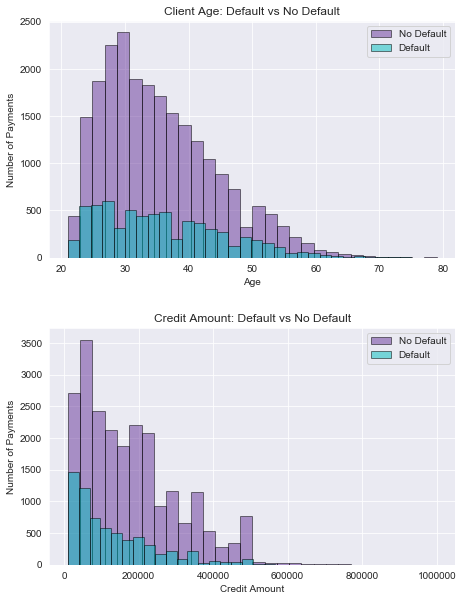

In [108]:
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df["default_payment_next_month"] == 0].AGE, bins = 30, label = "No Default", alpha = .50,edgecolor= "black", color = "rebeccapurple")
ax1.hist(df[df["default_payment_next_month"] == 1].AGE, bins = 30, label = "Default", alpha = .50, edgecolor = "black", color = "c")
ax1.set_title("Client Age: Default vs No Default")
ax1.set_xlabel("Age")
ax1.set_ylabel("Number of Payments")
ax1.legend(loc = "upper right")

ax2 = fig.add_subplot(223)
ax2.hist(df[df["default_payment_next_month"] == 0].LIMIT_BAL, bins = 30, label = "No Default", alpha = .50, edgecolor = "black", color = "rebeccapurple")
ax2.hist(df[df["default_payment_next_month"]==1].LIMIT_BAL, bins = 25, label = "Default", alpha = .50, edgecolor = "black", color = "c")
ax2.set_title("Credit Amount: Default vs No Default")
ax2.set_xlabel("Credit Amount")
ax2.set_ylabel("Number of Payments")
ax2.legend(loc = "upper right")


plt.show()

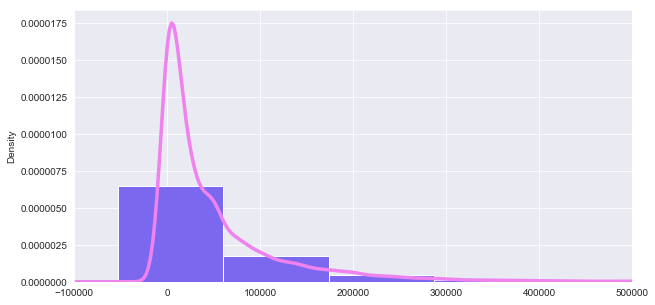

In [131]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT1"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT1"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

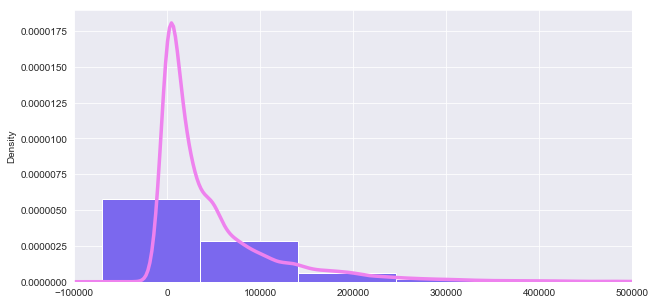

In [132]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT2"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT2"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

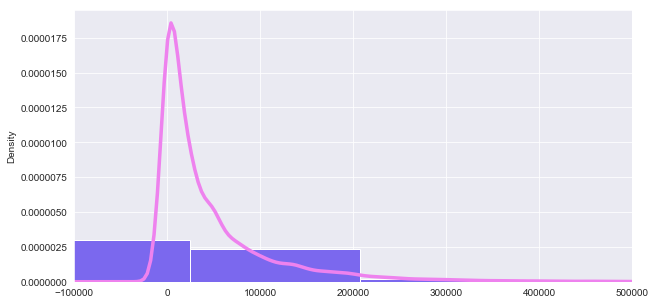

In [139]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT3"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT3"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

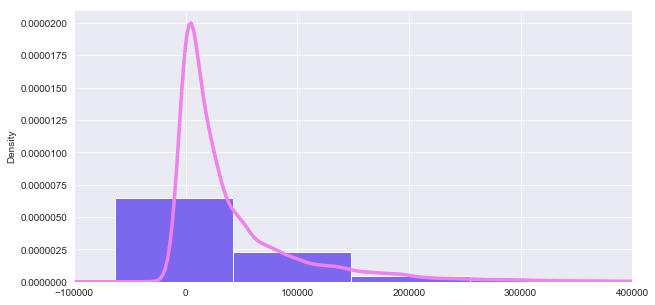

In [143]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT4"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT4"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

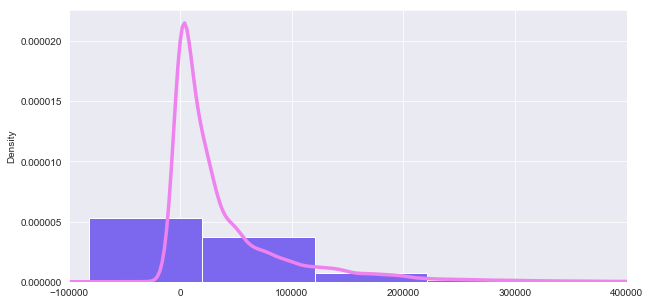

In [144]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT5"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT5"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

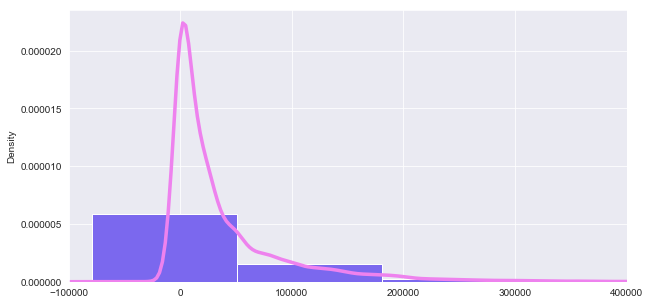

In [145]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT6"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT6"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

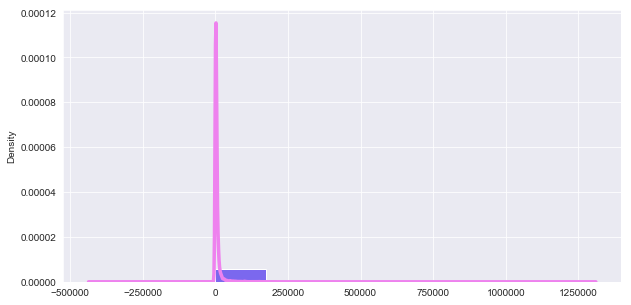

In [156]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT1"].plot.hist(normed = True, color = "mediumslateblue", bins = 5)
df["PAY_AMT1"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

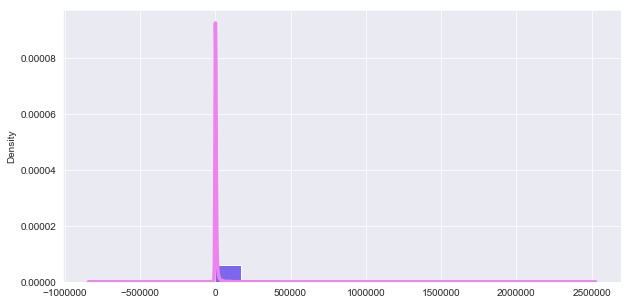

In [157]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT2"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT2"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

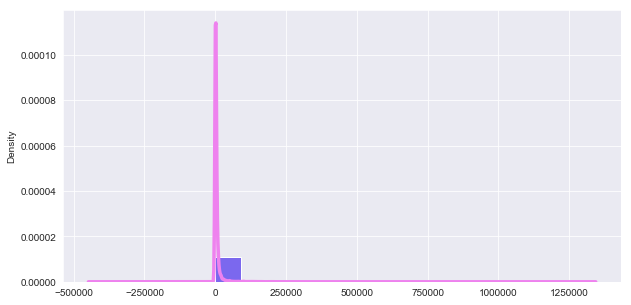

In [158]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT3"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT3"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

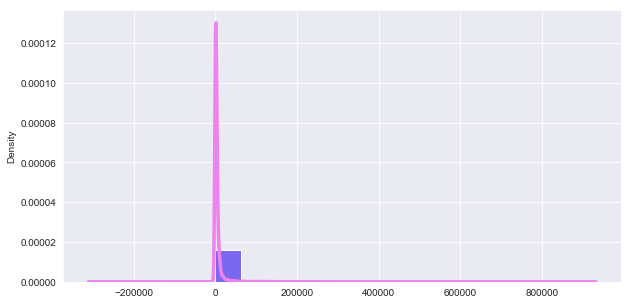

In [159]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT4"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT4"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

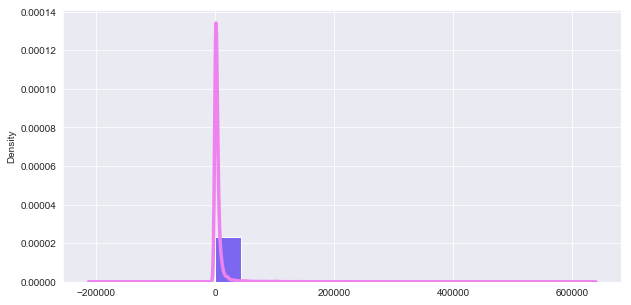

In [160]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT5"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT5"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

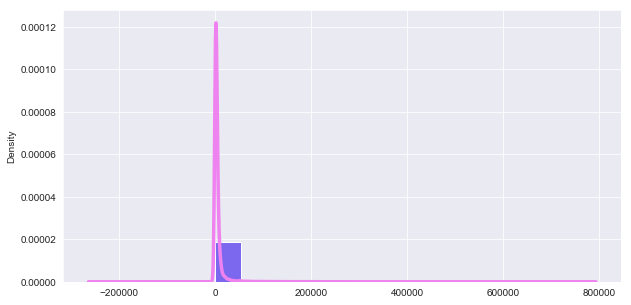

In [161]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT6"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT6"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

# Train-Test-Split

In [ ]:
# Define Target and Features
target = df.default_payment_next_month
features = df[["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3"
              "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", 
              "PAY_AMT5", "PAY_AMT6"]]
df_base.shape
# Split the data into train and test set
 X_train, X_test, y_train, y_test = train_test_split()

# Feature Transformation: Outliers, Scale, Standardize

In [ ]:
# Use MinMax Scaler to scale X
scaler = MinMaxScaler(feature_range=(0, 1))



In [162]:
# Outlier Detection with Modified Z-Score Method
def outliers_modified_z_score(data, th):
    threshold = th
    
    median_y = np.median(data)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in data])
    modified_z_score = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in data]
    return np.where(np.abs(modified_z_score) > threshold)


In [172]:
# Define the number of inliers and outliers
outliers_fraction = 0.25
clusters_separation = [0]

random_state = np.random.RandomState(42)

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

# Create a dictionary and add all the outlier detection models
classifiers = {"Angle-based Outlier Detector (ABOD)": ABOD(contamination=outliers_fraction),
                "Isolation Forest": IForest(contamination=outliers_fraction, random_state=random_state),
                "K Nearest Neighbors (KNN)": KNN(contamination=outliers_fraction)}

# Feature Engineering

In [ ]:
# Class Imbalance
# Marriage and Limit_bal interaction
# Age and limit bal interaction
# Amount/bill (rate of payment)
# amount/limit bal (rate of payment schedule)